In [235]:
from typing import List, Tuple
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener

COLORS = ('blue', 'green', 'red')

def to_std_float(image: np.ndarray) -> np.ndarray:
    """Converts image to 0 to 1 float to avoid wrapping that occurs with uint8"""
    image.astype(np.float16, copy=False)
    image = np.multiply(image, 1/255)
    return image

def to_std_uint8(image: np.ndarray) -> np.ndarray:
    """Properly handles the conversion to uint8"""
    image = cv2.convertScaleAbs(image, alpha=255)
    return image

def show_images(images: List[np.ndarray], labels: List[str]=None, max_num_cols: int=4, fig_size: Tuple[int, int]=None):
    """
    Shows a grid of images (color space = BGR, shape = (h, w, c))
    """
    ncols = min(len(images), max_num_cols)
    nrows = math.ceil(len(images) / ncols)
    if not fig_size:
        fig_size = (5 * ncols, 5 * nrows)
    fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=fig_size)
    for i, image in enumerate(images):
        ax = axs[divmod(i, ncols)]
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if labels:
            ax.set_title(labels[i])

def show_image_histograms(images: List[np.ndarray], labels: List[str]=None, max_freq: int=None, max_num_cols: int=4, fig_size: Tuple[int, int]=None):
    """
    Shows a grid of image histograms (color space = BGR, shape = (h, w, c))
    """
    ncols = min(len(images), max_num_cols)
    nrows = math.ceil(len(images) / ncols)
    if not fig_size:
        fig_size = (5 * ncols, 5 * nrows)
    if not max_freq:
        max_freq = images[0].size / 16
    fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=fig_size)
    for i, image in enumerate(images):
        ax = axs[divmod(i, ncols)]
        for c in range(3):
            ax.hist(image[:, :, c].flatten(), color=COLORS[c], bins=256, label=COLORS[c], histtype='step', alpha=0.5)
            ax.set_ylim(0, max_freq)
        if labels:
            ax.set_title(labels[i])

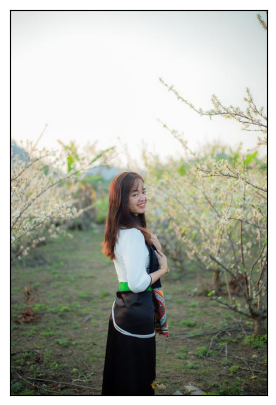

In [236]:
original_image = cv2.imread('../images/face_unlabeled_face_unlabeled_addnoise_eps16_testnum0_00000169.jpg.jpg')
show_images([original_image])

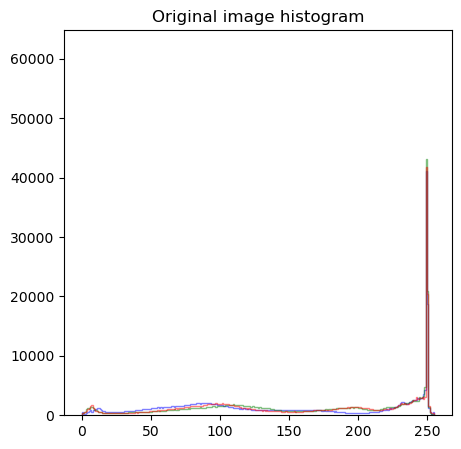

In [237]:
show_image_histograms([original_image], ['Original image histogram'])

# Salt-and-pepper noise

## Creating salt-and-pepper noise

In [238]:
def add_salt_and_pepper(image: np.ndarray, noise_prob: float=0.1) -> np.ndarray:
    """Converts pixels of `image` to black or white independently each with probability `noise_prob`"""
    image = to_std_float(image)
    white_value = int(2 / noise_prob)
    noise = np.random.randint(white_value + 1, size=(image.shape[0], image.shape[1], 1))
    image = np.where(noise == 0, 0, image)
    image = np.where(noise == white_value, 1, image)
    image = to_std_uint8(image)
    return image

In [239]:
salt_and_pepper_image = add_salt_and_pepper(original_image)

## Median blur

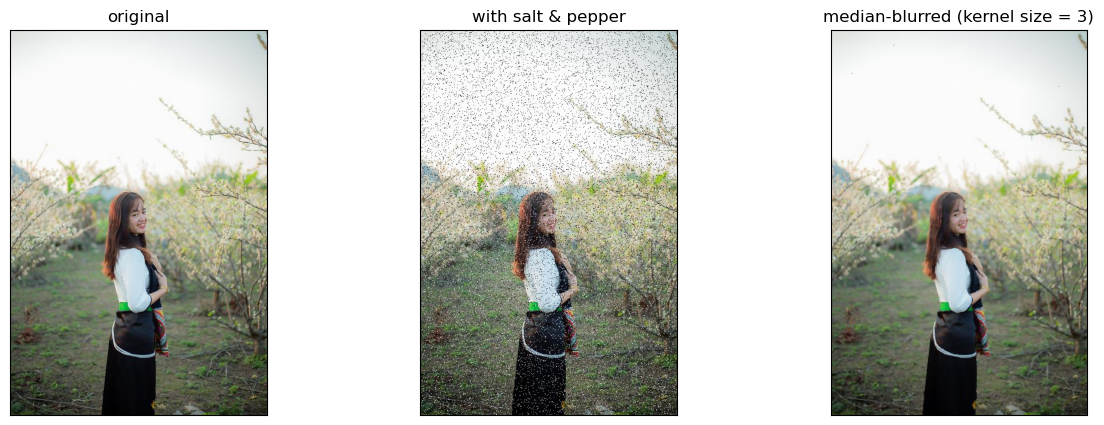

In [240]:
median_kernel_size = 3
median_image = cv2.medianBlur(salt_and_pepper_image, median_kernel_size)
show_images([original_image, salt_and_pepper_image, median_image],
            ['original', 'with salt & pepper', f'median-blurred (kernel size = {median_kernel_size})'])

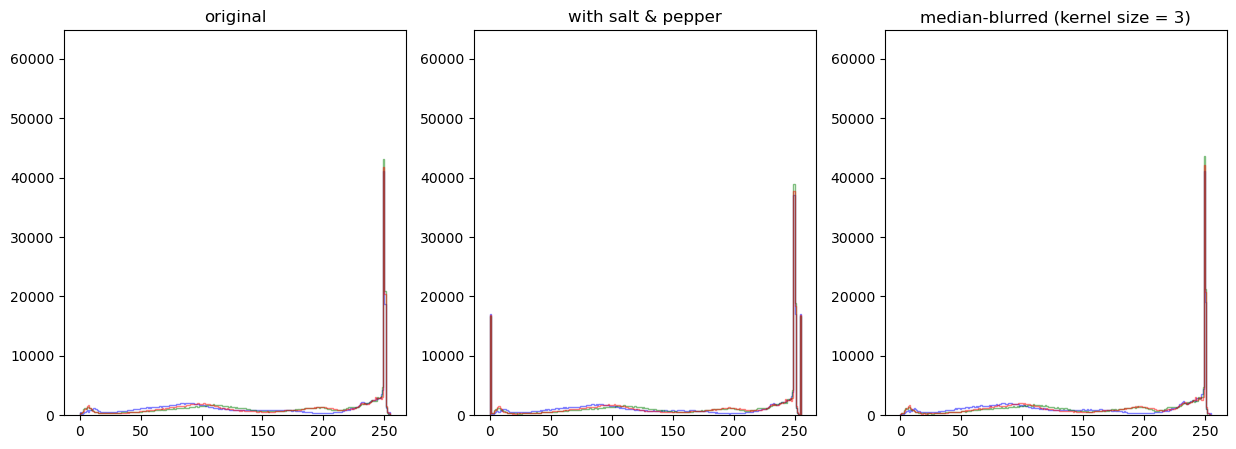

In [241]:
show_image_histograms([original_image, salt_and_pepper_image, median_image],
                      ['original', 'with salt & pepper', f'median-blurred (kernel size = {median_kernel_size})'])

# Gaussian noise

## Creating Gaussian noise

In [242]:
def add_gaussian_noise(image: np.ndarray, std_dev: float=0.2):
    image = to_std_float(image)
    noise = np.random.normal(0, std_dev, (image.shape[0],image.shape[1], 3))
    image += noise
    image = to_std_uint8(image)
    return image

In [243]:
gaussian_noise_image = add_gaussian_noise(original_image)

## Mean filter

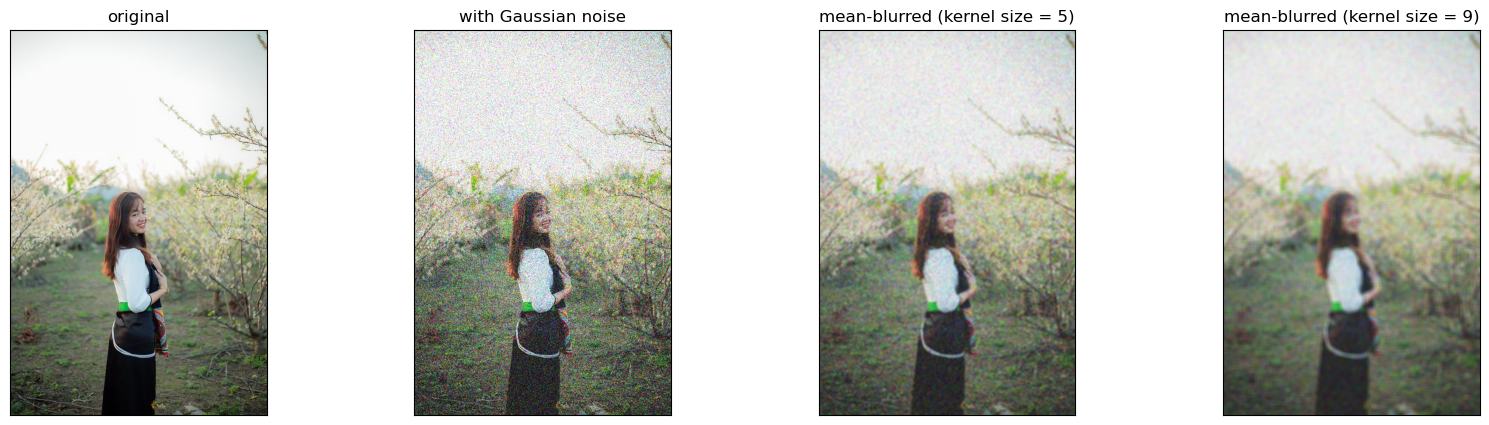

In [244]:
mean_kernel_sizes = [5, 9]
mean_images = [cv2.blur(gaussian_noise_image, (k, k)) for k in mean_kernel_sizes]
show_images([original_image, gaussian_noise_image] + mean_images,
            ['original', 'with Gaussian noise'] + [f'mean-blurred (kernel size = {s})' for s in mean_kernel_sizes])

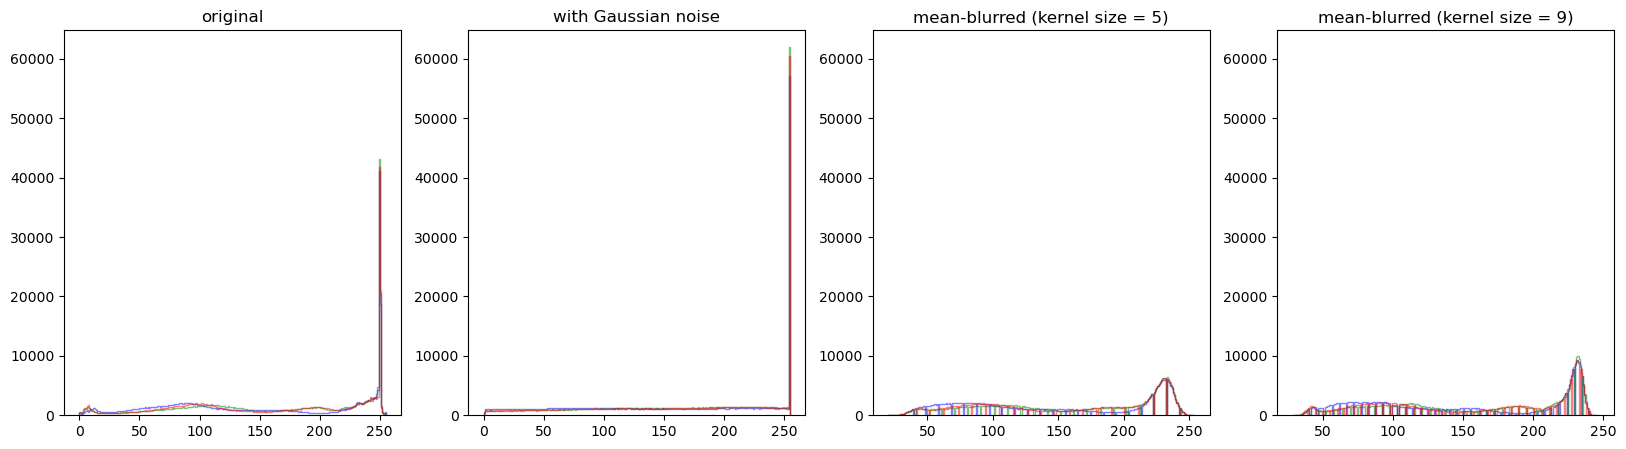

In [245]:
show_image_histograms([original_image, gaussian_noise_image] + mean_images,
                      ['original', 'with Gaussian noise'] + [f'mean-blurred (kernel size = {s})' for s in mean_kernel_sizes])

## Gaussian smoothing

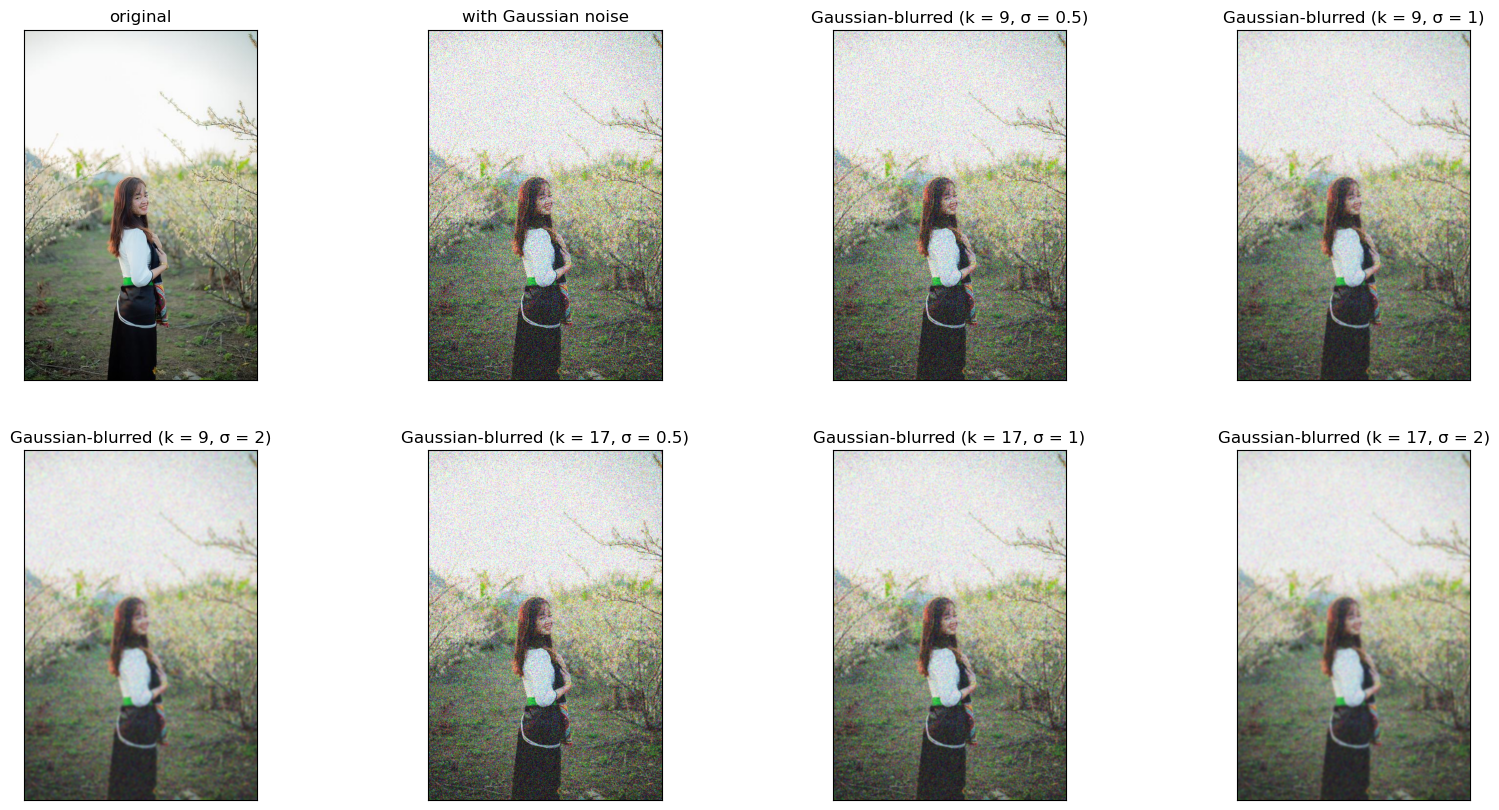

In [246]:
gaussian_kernel_sizes = [9, 17]
sigmas = [0.5, 1, 2]
gaussian_images = [cv2.GaussianBlur(gaussian_noise_image, (k, k), s)
                   for k in gaussian_kernel_sizes
                   for s in sigmas]
show_images([original_image, gaussian_noise_image] + gaussian_images,
            ['original', 'with Gaussian noise']
            + [f'Gaussian-blurred (k = {k}, σ = {s})'
               for k in gaussian_kernel_sizes
               for s in sigmas])

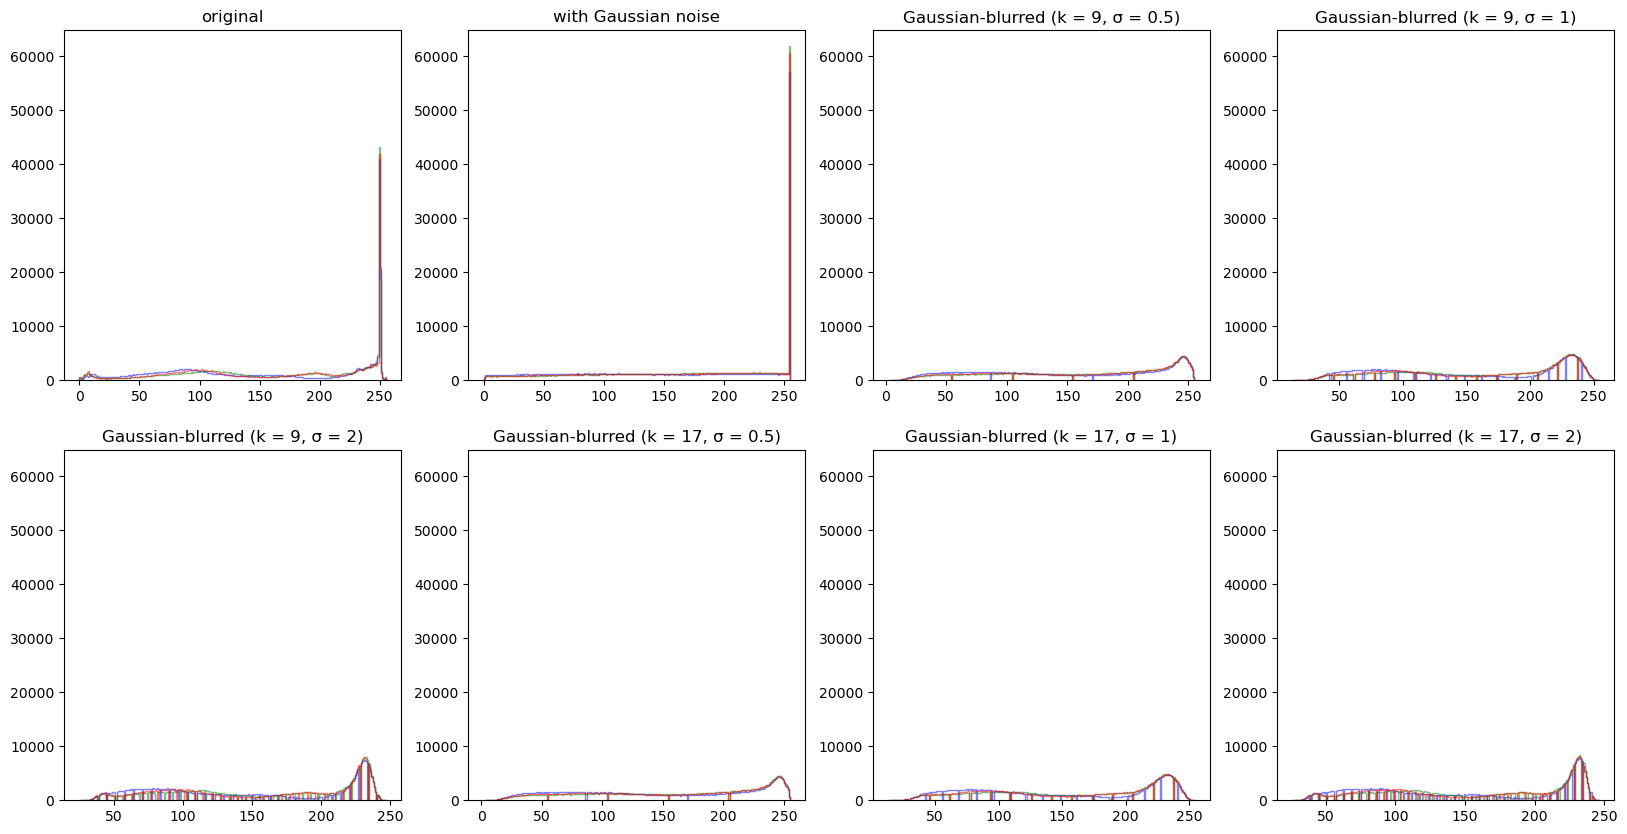

In [247]:
show_image_histograms([original_image, gaussian_noise_image] + gaussian_images,
                      ['original', 'with Gaussian noise']
                      + [f'Gaussian-blurred (k = {k}, σ = {s})' for k in gaussian_kernel_sizes for s in sigmas])